In [30]:
#install.packages('randomForest')
library(readxl)
library(randomForest)
library(tidyverse)
#install.packages('dplyr')
library(dplyr)
library(Rcpp)


library(rpart)# Popular decision tree algorithm
#install.packages('rattle')
library(rattle)# Fancy tree plot
library(rpart.plot)# Enhanced tree plots
library(RColorBrewer)# Color selection for fancy tree plot
library(party) # Alternative decision tree algorithm
#install.packages('partykit')
library(partykit)# Convert rpart object to BinaryTree

#install.packages('tree')
library(tree)
#install.packages('multcomp')
library(multcomp)
#install.packages('party')


#install.packages('Metrics')
library(Metrics)
#install.packages('reprtree')
#devtools::install_github("MI2DataLab/randomForestExplainer")
#install.packages('randomForestExplainer')
library(randomForestExplainer)
#install.packages("scales")
library(scales)
#update.packages()
#install.packages("packagename")
require(foreign)
require(nnet)
require(ggplot2)
require(reshape2)
#install.packages("stats4")
#install.packages("splines")
library(stats4) #Load package stats
library(splines) #Load package splines
#To load package VGAM, need to load package stats4 and splines.
#install.packages("VGAM")
library(VGAM) #Load package VGAM


#install.packages("psych")
#install.packages("PerformanceAnalytics")
library(corrplot)
library(PerformanceAnalytics)
library(psych)

library(data.table)
library(writexl)



# FA (weighted) Classifcation

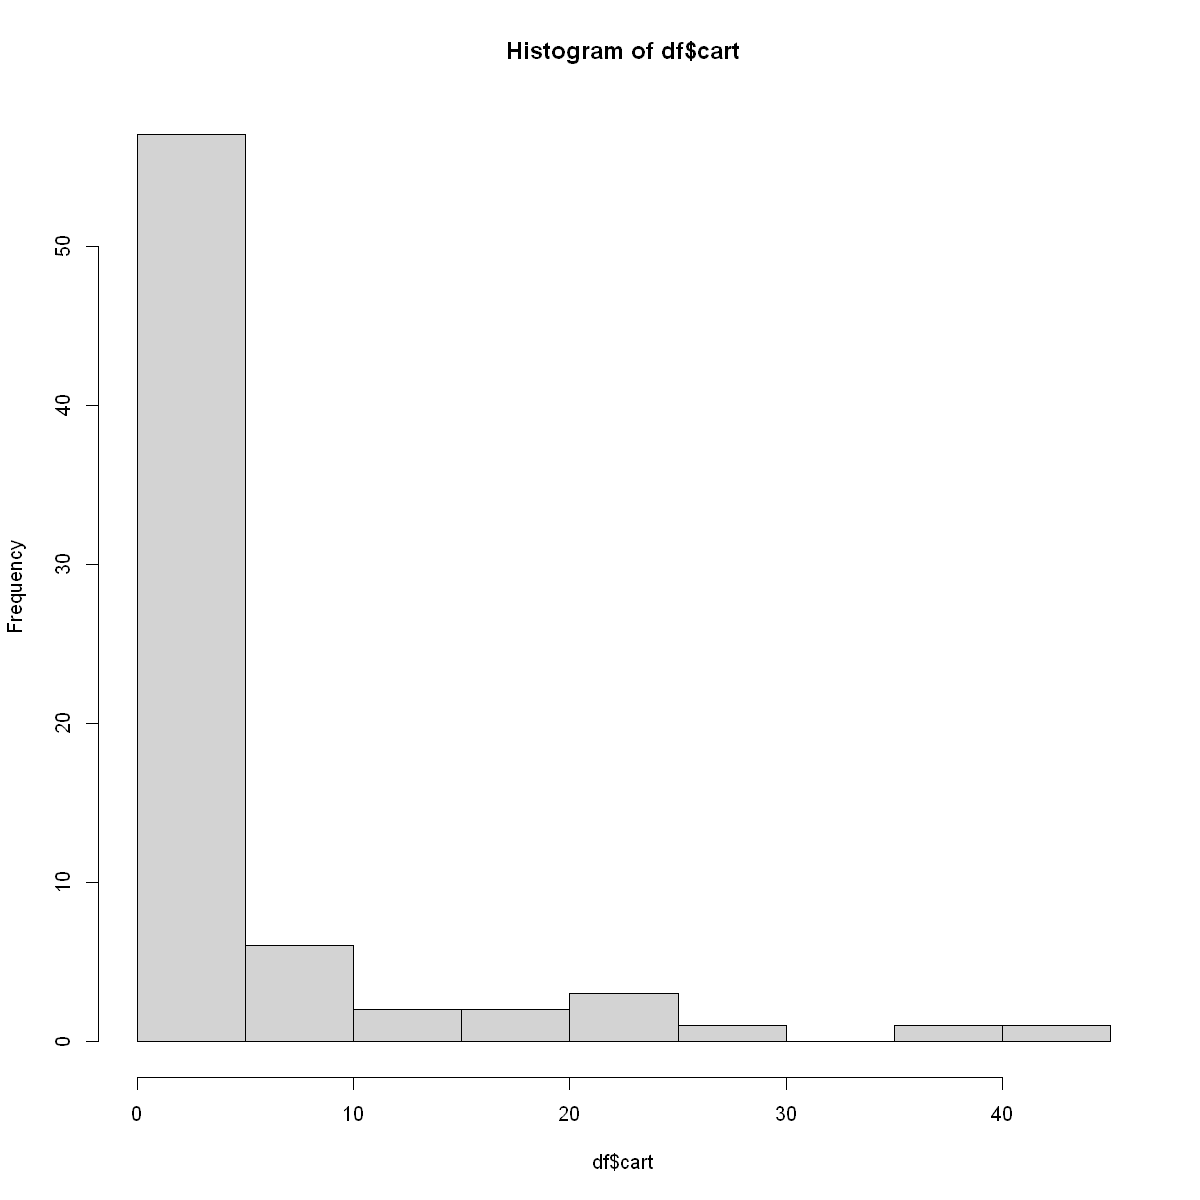

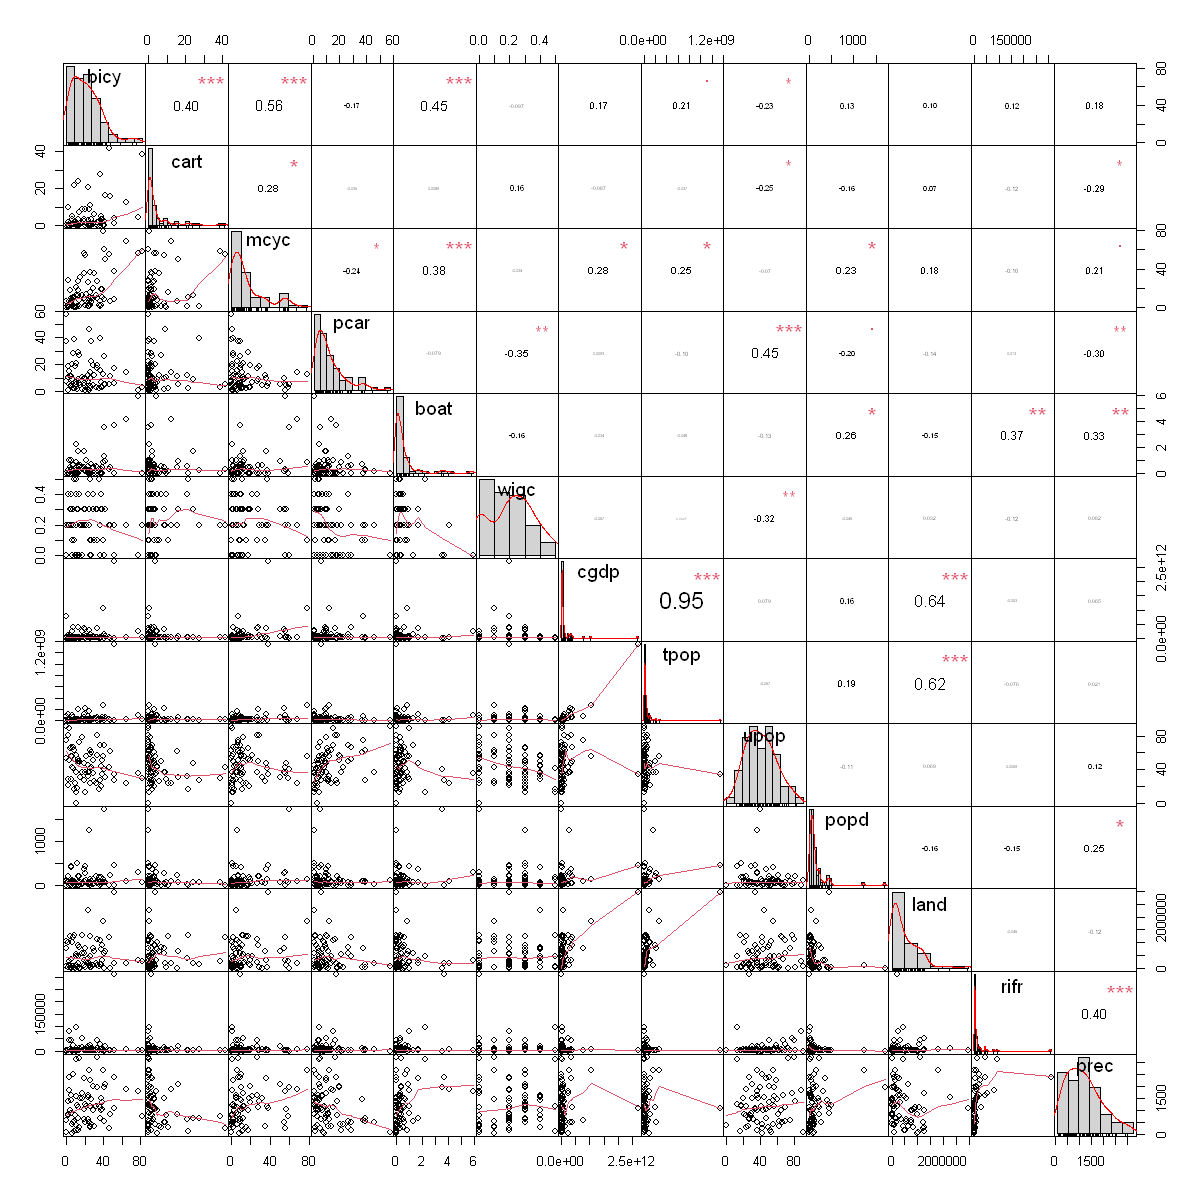

In [31]:
df.wa = read_excel( "../../results/df-water-access.xlsx" ,sheet=1)
df.exp =read_excel("../../results/df-water-explore.xlsx" ,sheet=1)
df.cluster = read_excel("../../results/df-fa-seven-cluster-rank.xlsx" ,sheet=1)
df.wb = read_excel("../../results/df-wb.xlsx" ,sheet=1 )
df.exp$clusters <- as.factor(df.cluster$clusters)
df <- merge(x = df.exp,
              y = df.wb,
              by = c("Country"))

df <- df[, c(1:13, 17,21)]

#scaling the world bank data similar to DHS aggregation out of 100
df.wb <- df[,c(9:15)]
df.wb <- data.frame(lapply(df.wb, function(x) scale(x, center = FALSE, scale = max(x, na.rm = TRUE)/100)))
df.scale <- cbind(df, df.wb)
df.scale <- df.scale[,c(1:8,15:21)]


df.a <- df[, c(1:6,8)]
hist(df$cart)

explnatory <- df[,c(2:7, 9:15)]
chart.Correlation(explnatory, histogram=TRUE, pch=19 , tl.cex = .7 )
                           


In [32]:
# ""Off-premise", "Market", ""
df <- df%>%
  mutate(clusters=case_when(
    .$clusters=="1" ~ "Off-premise",
    .$clusters=="2" ~ "Market",
    .$clusters=="3" ~ "Improved Drinking Water",
      ))

df.scale <- df.scale%>%
  mutate(clusters=case_when(
    .$clusters=="1" ~ "Off-premise",
    .$clusters=="2" ~ "Market",
    .$clusters=="3" ~ "Improved Drinking Water",
      ))


In [33]:
df$clusters <- as.factor(df$clusters)
df.scale$clusters <- as.factor(df.scale$clusters)
write_xlsx(df , '../../results/class.xlsx')
write_xlsx(df.scale , '../../results/class-scale.xlsx')
head(df)

,Country,bicy,cart,mcyc,pcar,boat,wigc,clusters,cgdp,tpop,upop,popd,land,rifr,prec
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Afghanistan,30.0,5.8,35.2,11.8,0.0,0.1,Off-premise,18353881130,37172386,25.495,56.93776,652860,1299.0269,327
2,Albania,26.4,3.2,9.6,37.0,0.7,0.1,Market,15147020535,2866376,60.319,104.61226,27400,9361.5460,1485
3,Angola,4.6,1.3,17.8,10.9,0.4,0.3,Off-premise,101353230785,30809762,65.514,24.71305,1246700,4963.6533,1010
4,Armenia,8.6,0.4,0.2,39.2,0.3,0.1,Improved Drinking Water,12457941907,2951776,63.149,103.68022,28470,2329.1833,562
5,Azerbaijan,6.9,3.3,1.1,20.4,0.1,0.0,Improved Drinking Water,47112941176,9939771,55.680,120.23432,82670,823.5207,447
6,Bangladesh,25.1,0.0,6.4,0.8,0.0,0.3,Market,274039092455,161356039,36.632,1239.57931,130170,657.6039,2666


# Tree

In [34]:
# Make big tree
form <- as.formula(clusters ~ . - Country)
tree.fwa <- rpart(form,data=df,control=rpart.control(minsplit=4,cp=0.01, xval = nrow(df), maxsurrogate = 0, minbucket = 4 )
                 )

par(mar=c(1,1,1,1))

png(
  "cp.png",
  width     = 5,
  height    = 5,
  units     = "in",
  res       = 700,
  #pointsize = 6
)

#plot(tree.fwa)# Will make a mess of the plot
#text(tree.fwa)

plotcp(tree.fwa)

dev.off()

printcp(tree.fwa)

#summary(tree.fwa) 
#prp(tree.fwa)# Will plot the tree
#prp(tree.fwa,varlen=4)# Shorten variable names

png 
  2


Classification tree:
rpart(formula = form, data = df, control = rpart.control(minsplit = 4, 
    cp = 0.01, xval = nrow(df), maxsurrogate = 0, minbucket = 4))

Variables actually used in tree construction:
[1] boat cgdp pcar popd prec

Root node error: 36/73 = 0.49315

n= 73 

        CP nsplit rel error  xerror    xstd
1 0.388889      0   1.00000 1.00000 0.11866
2 0.138889      1   0.61111 0.80556 0.11613
3 0.083333      2   0.47222 0.75000 0.11458
4 0.055556      3   0.38889 0.72222 0.11365
5 0.027778      4   0.33333 0.72222 0.11365
6 0.010000      6   0.27778 0.72222 0.11365


ERROR: Error in legend(x = x, y = y, legend = legend, col = 0, xpd = NA, bty = "n", : argument 8 matches multiple formal arguments


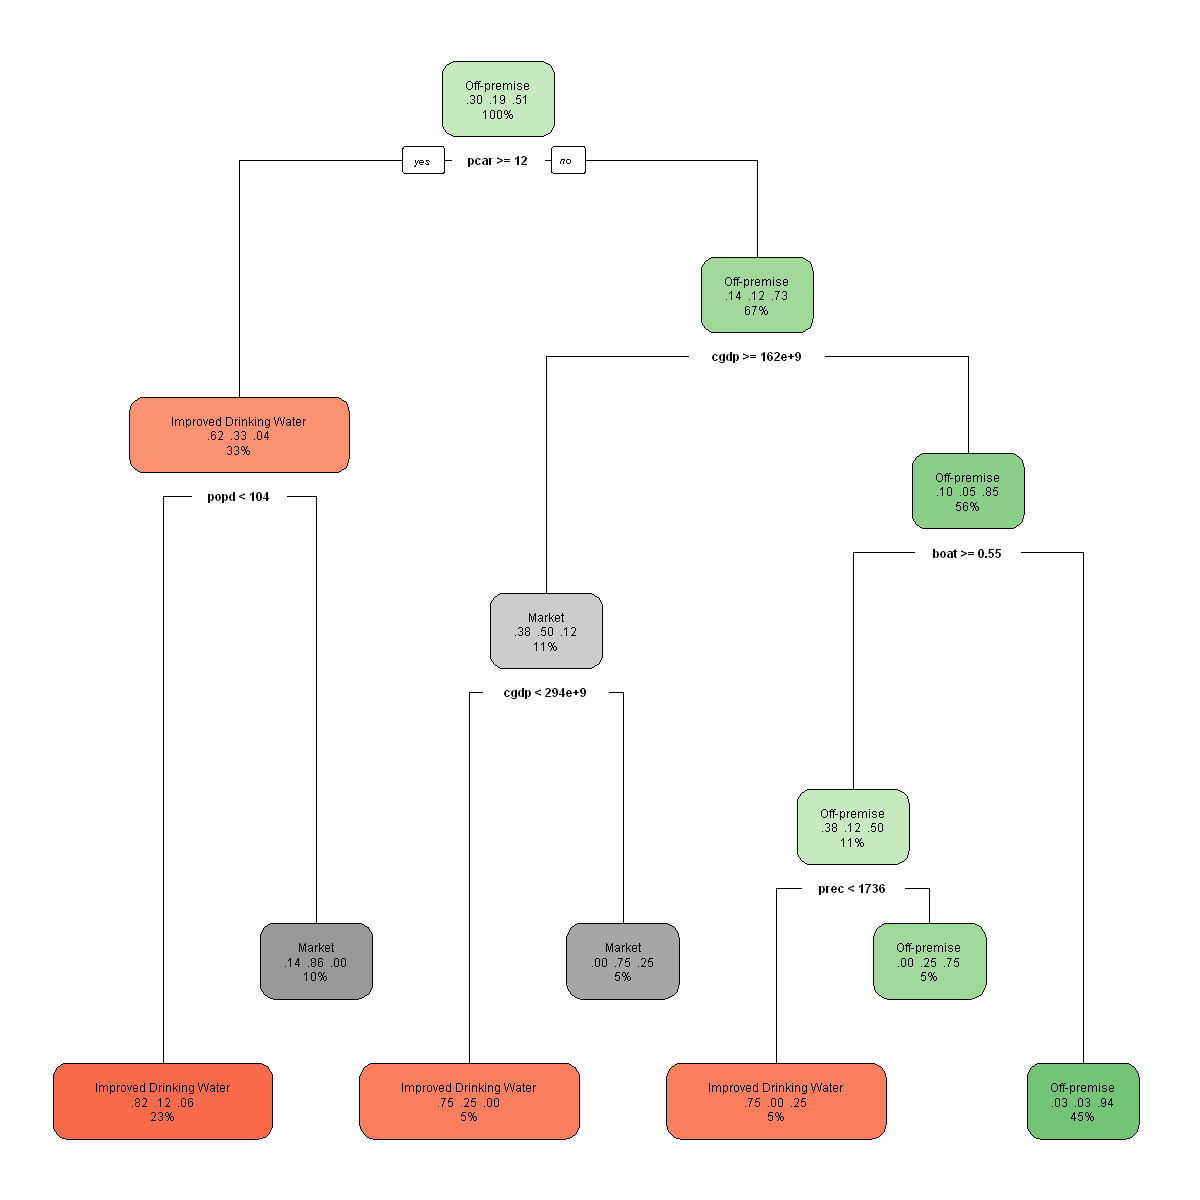

In [35]:
#size of the plot 
options(repr.plot.width=10, repr.plot.height=10)
par(mar = c(1,1,1,1))
par(cex=1)

#Interatively prune the tree
tree.pru <- prune(tree.fwa, cp=0.017) # interactively trim the tree
#prp(tree.pru) # display the new tree
rpart.plot(tree.pru)

In [36]:
par(mar=c(1,1,1,1))

png(
  "rpart.png",
  width     = 6,
  height    = 6,
  units     = "in",
  res       = 800,
  #pointsize = 6
)

fancyRpartPlot(tree.pru)


dev.off()

summary(tree.pru)

png 
  2

Call:
rpart(formula = form, data = df, control = rpart.control(minsplit = 4, 
    cp = 0.01, xval = nrow(df), maxsurrogate = 0, minbucket = 4))
  n= 73 

          CP nsplit rel error    xerror      xstd
1 0.38888889      0 1.0000000 1.0000000 0.1186556
2 0.13888889      1 0.6111111 0.8055556 0.1161345
3 0.08333333      2 0.4722222 0.7500000 0.1145768
4 0.05555556      3 0.3888889 0.7222222 0.1136506
5 0.02777778      4 0.3333333 0.7222222 0.1136506
6 0.01000000      6 0.2777778 0.7222222 0.1136506

Variable importance
pcar cgdp popd boat prec 
  43   25   18    7    6 

Node number 1: 73 observations,    complexity param=0.3888889
  predicted class=Off-premise              expected loss=0.4931507  P(node) =1
    class counts:    22    14    37
   probabilities: 0.301 0.192 0.507 
  left son=2 (24 obs) right son=3 (49 obs)
  Primary splits:
      pcar < 12.4         to the right, improve=12.198510, (0 missing)
      wigc < 0.25         to the left,  improve= 6.923826, (0 missing)
     

Warning message:
"ignoring snip=TRUE for png device"


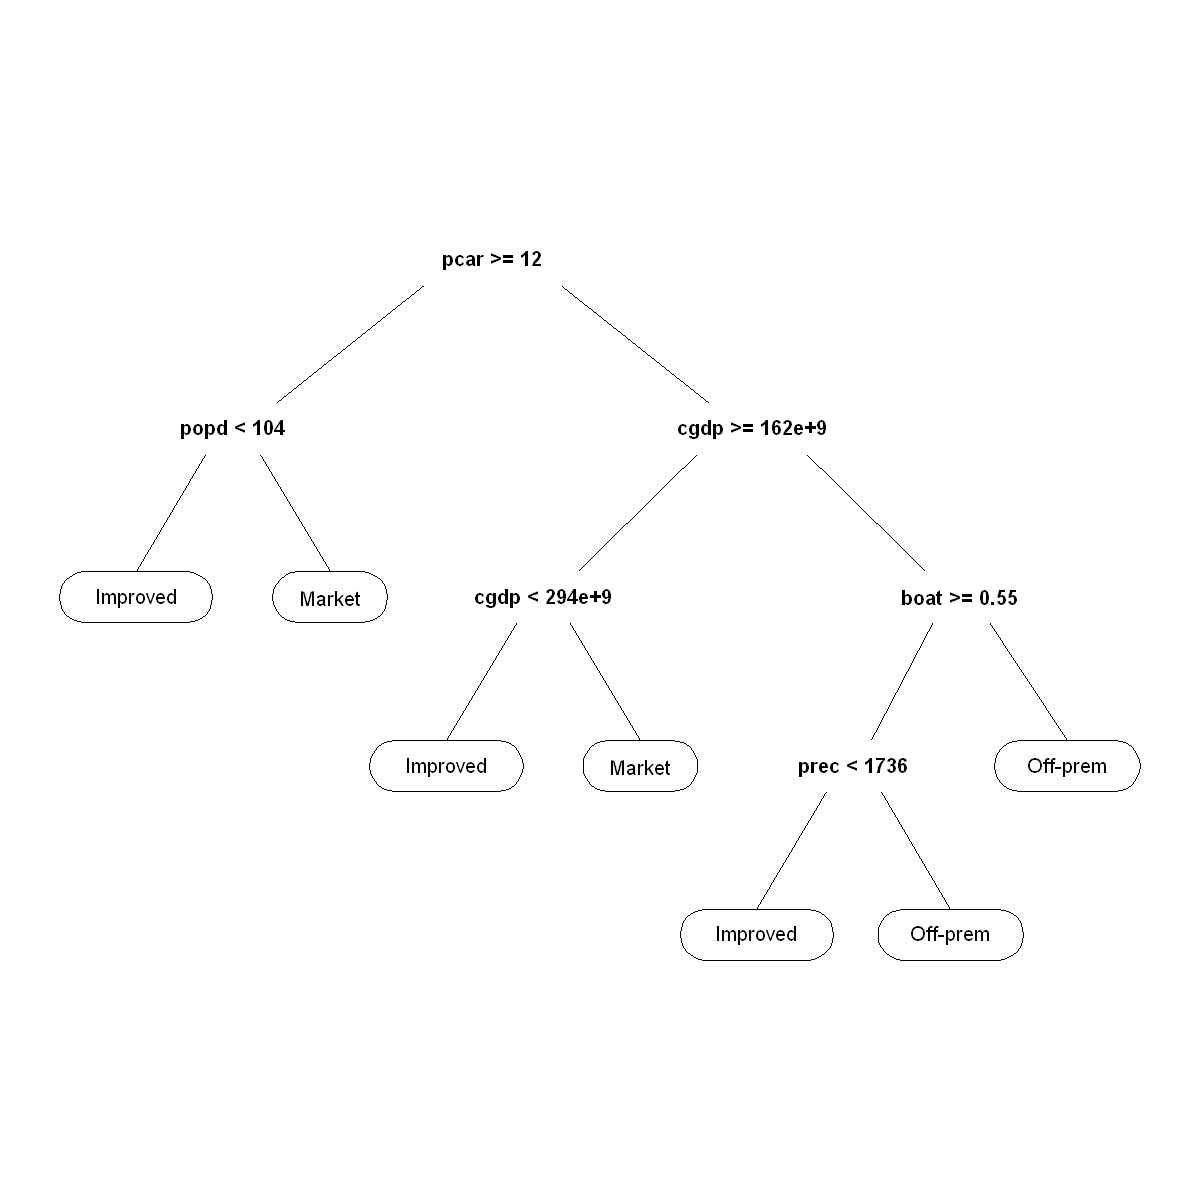

In [37]:
prp(tree.fwa, snip=TRUE)

http://www.milbo.org/rpart-plot/prp.pdf
http://www.di.fc.ul.pt/~jpn/r/tree/tree.html


Classification tree:
tree(formula = clusters ~ . - Country, data = df.scale)
Variables actually used in tree construction:
[1] "pcar" "cgdp" "land" "boat" "bicy" "popd" "prec"
Number of terminal nodes:  8 
Residual mean deviance:  0.8264 = 53.72 / 65 
Misclassification error rate: 0.1644 = 12 / 73 

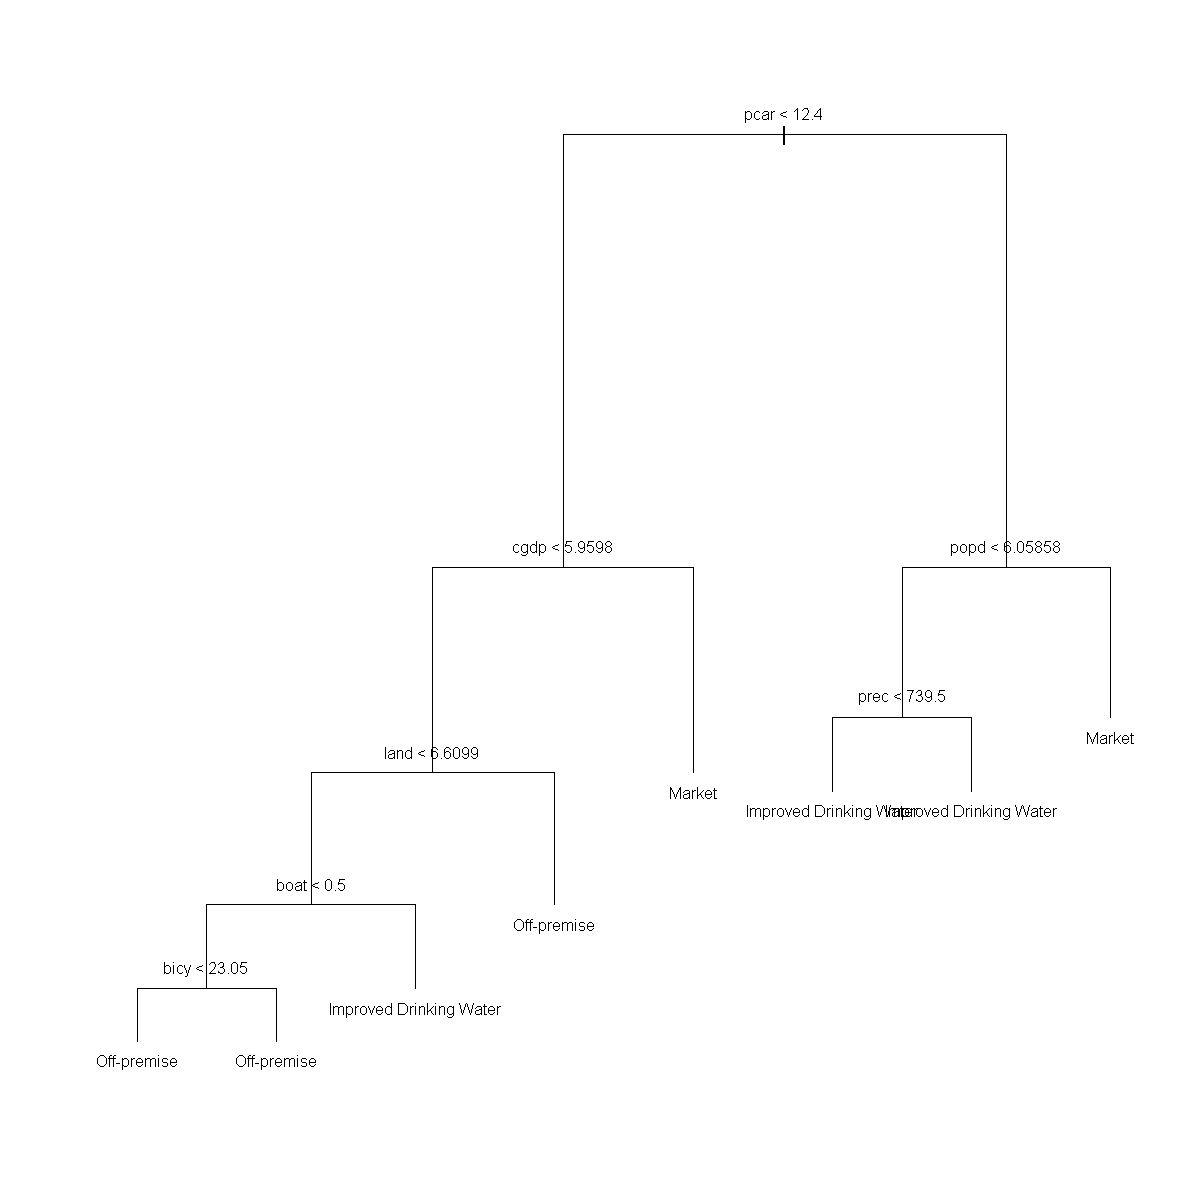

In [38]:
tree.wa = tree(clusters ~ . - Country  , data = df.scale)
summary(tree.wa) 
plot(tree.wa)
text(tree.wa, pretty = 0 , cex=.8) 


Classification tree:
tree(formula = clusters ~ . - Country, data = df, mindev = 0.01)
Variables actually used in tree construction:
[1] "pcar" "cgdp" "land" "boat" "bicy" "popd" "prec"
Number of terminal nodes:  8 
Residual mean deviance:  0.8264 = 53.72 / 65 
Misclassification error rate: 0.1644 = 12 / 73 

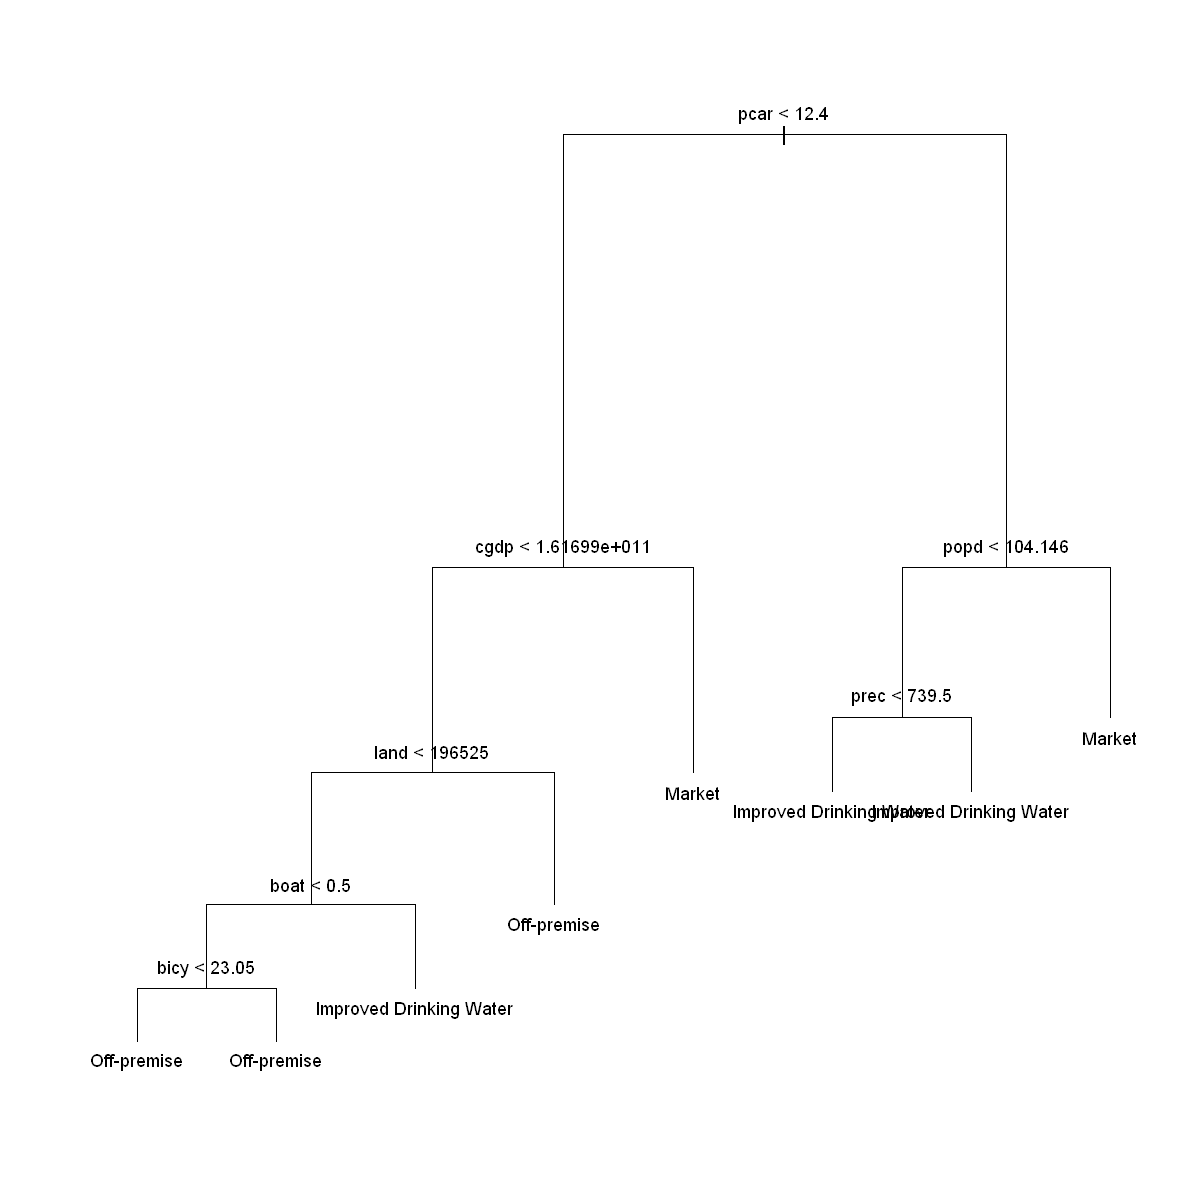

In [39]:
tree.wa = tree(clusters ~ . - Country  , data = df, mindev=0.01, )
summary(tree.wa) 
plot(tree.wa)
text(tree.wa, pretty = 0 , cex=.90) 

# Distributional prediction
my.prediction <- predict(tree.wa) # gives the probability for each class
head(my.prediction)

# Point prediction
# Let's translate the probability output to categorical output
maxidx <- function(arr) {
    return(which(arr == max(arr)))
}
idx <- apply(my.prediction, c(1), maxidx)
prediction <- c("Worst Water Source", "Better Water Source", "Best Water Source")[idx]
table(prediction, df.scale$clusters)

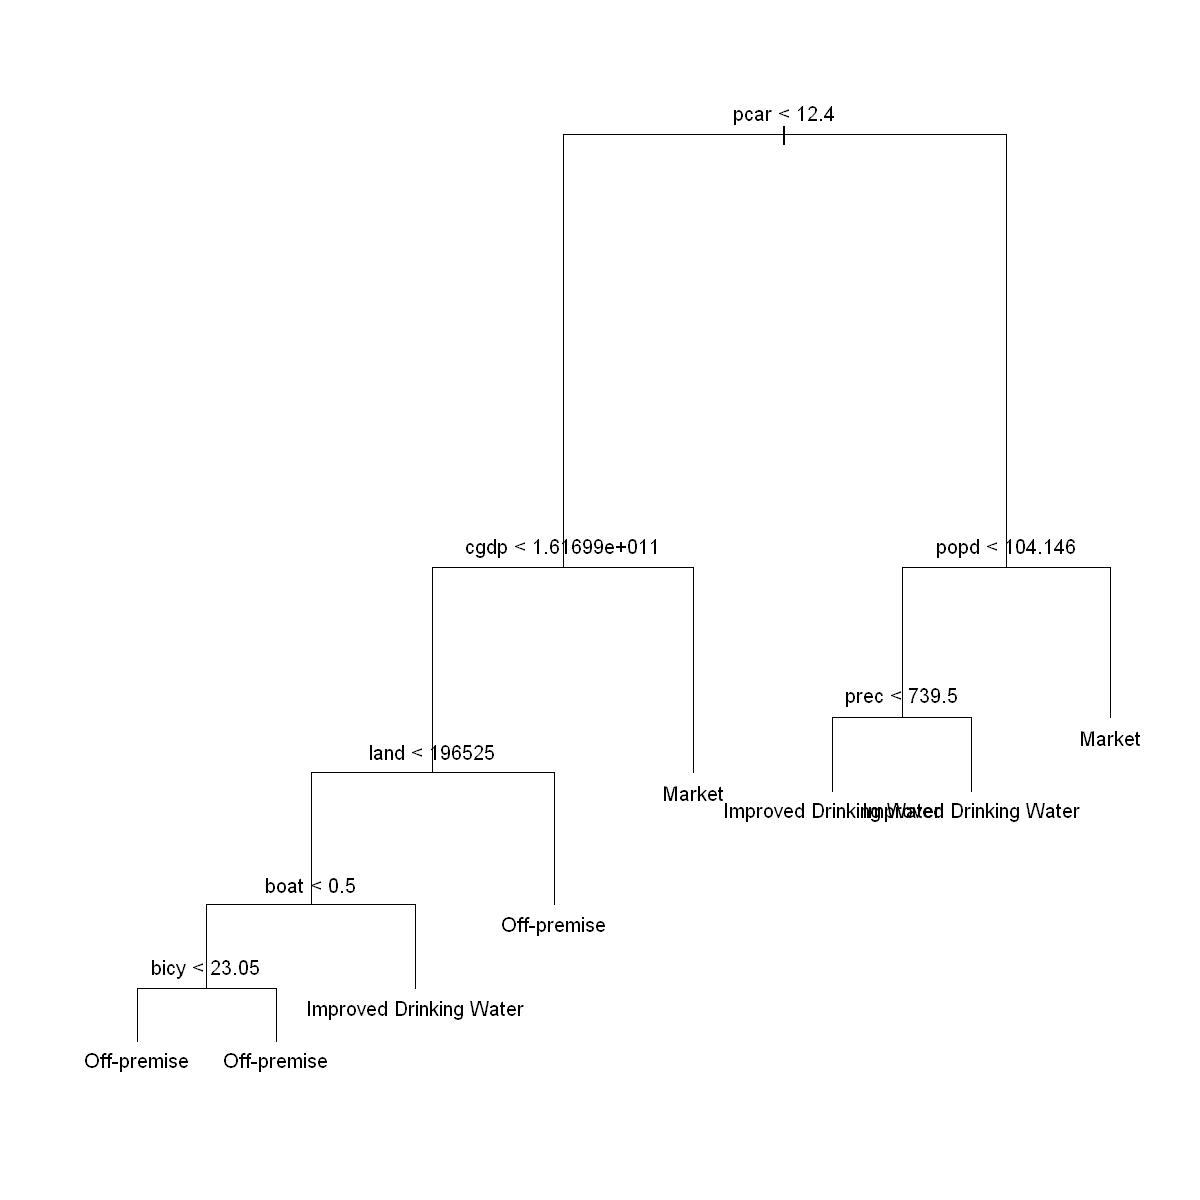

In [40]:
plot(tree.wa)
text(tree.wa)


Classification tree:
snip.tree(tree = tree.wa, nodes = c(16L, 6L))
Variables actually used in tree construction:
[1] "pcar" "cgdp" "land" "boat" "popd"
Number of terminal nodes:  6 
Residual mean deviance:  0.9617 = 64.43 / 67 
Misclassification error rate: 0.1644 = 12 / 73 

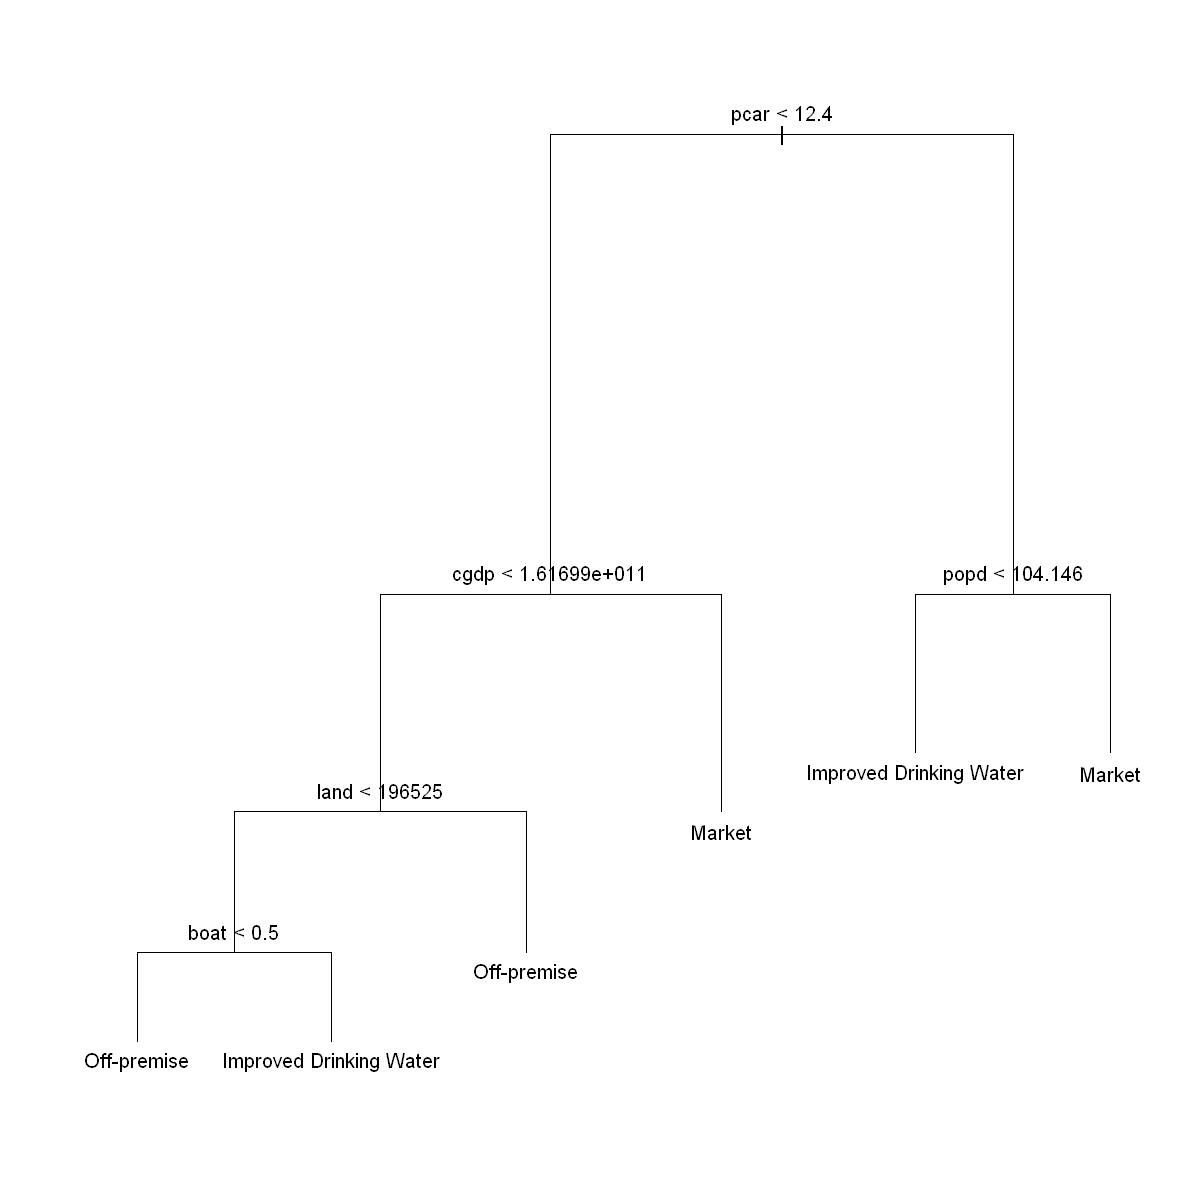

In [41]:
pru.wa <- prune.tree(tree.wa, best = 6 )
summary(pru.wa)
plot(pru.wa)
text(pru.wa, pretty = 0)


# Random Forest


Call:
 randomForest(formula = clusters ~ . - Country, data = df, ntree = 200,      mtry = 12) 
               Type of random forest: classification
                     Number of trees: 200
No. of variables tried at each split: 12

        OOB estimate of  error rate: 34.25%
Confusion matrix:
                        Improved Drinking Water Market Off-premise class.error
Improved Drinking Water                      12      5           5   0.4545455
Market                                        6      5           3   0.6428571
Off-premise                                   5      1          31   0.1621622


                Length Class  Mode     
call              5    -none- call     
type              1    -none- character
predicted        73    factor numeric  
err.rate        800    -none- numeric  
confusion        12    -none- numeric  
votes           219    matrix numeric  
oob.times        73    -none- numeric  
classes           3    -none- character
importance       13    -none- numeric  
importanceSD      0    -none- NULL     
localImportance   0    -none- NULL     
proximity         0    -none- NULL     
ntree             1    -none- numeric  
mtry              1    -none- numeric  
forest           14    -none- list     
y                73    factor numeric  
test              0    -none- NULL     
inbag             0    -none- NULL     
terms             3    terms  call     

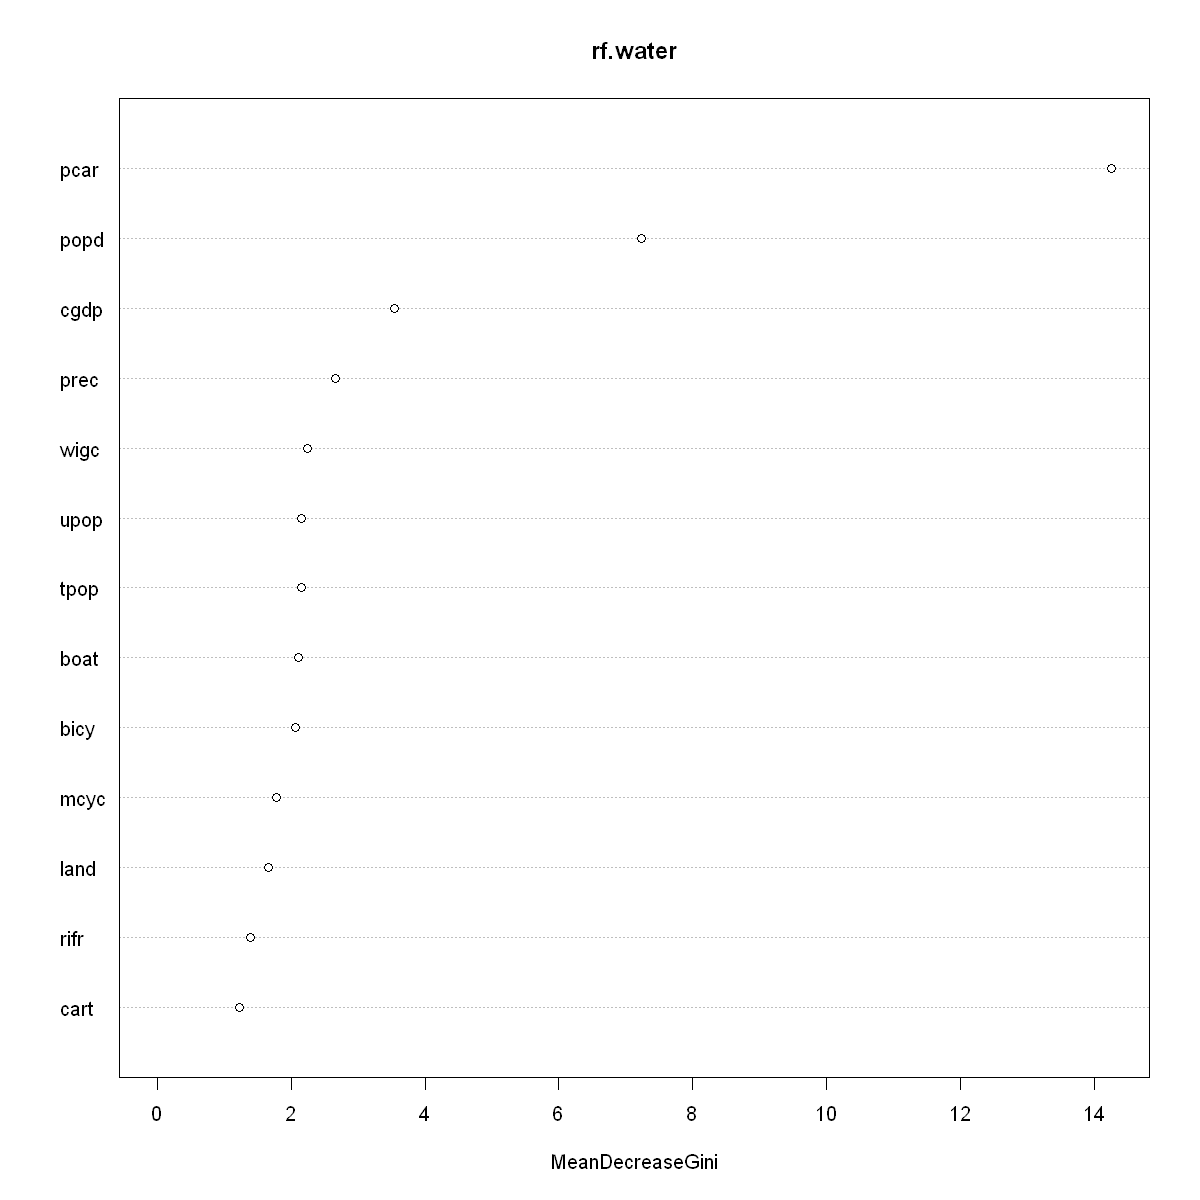

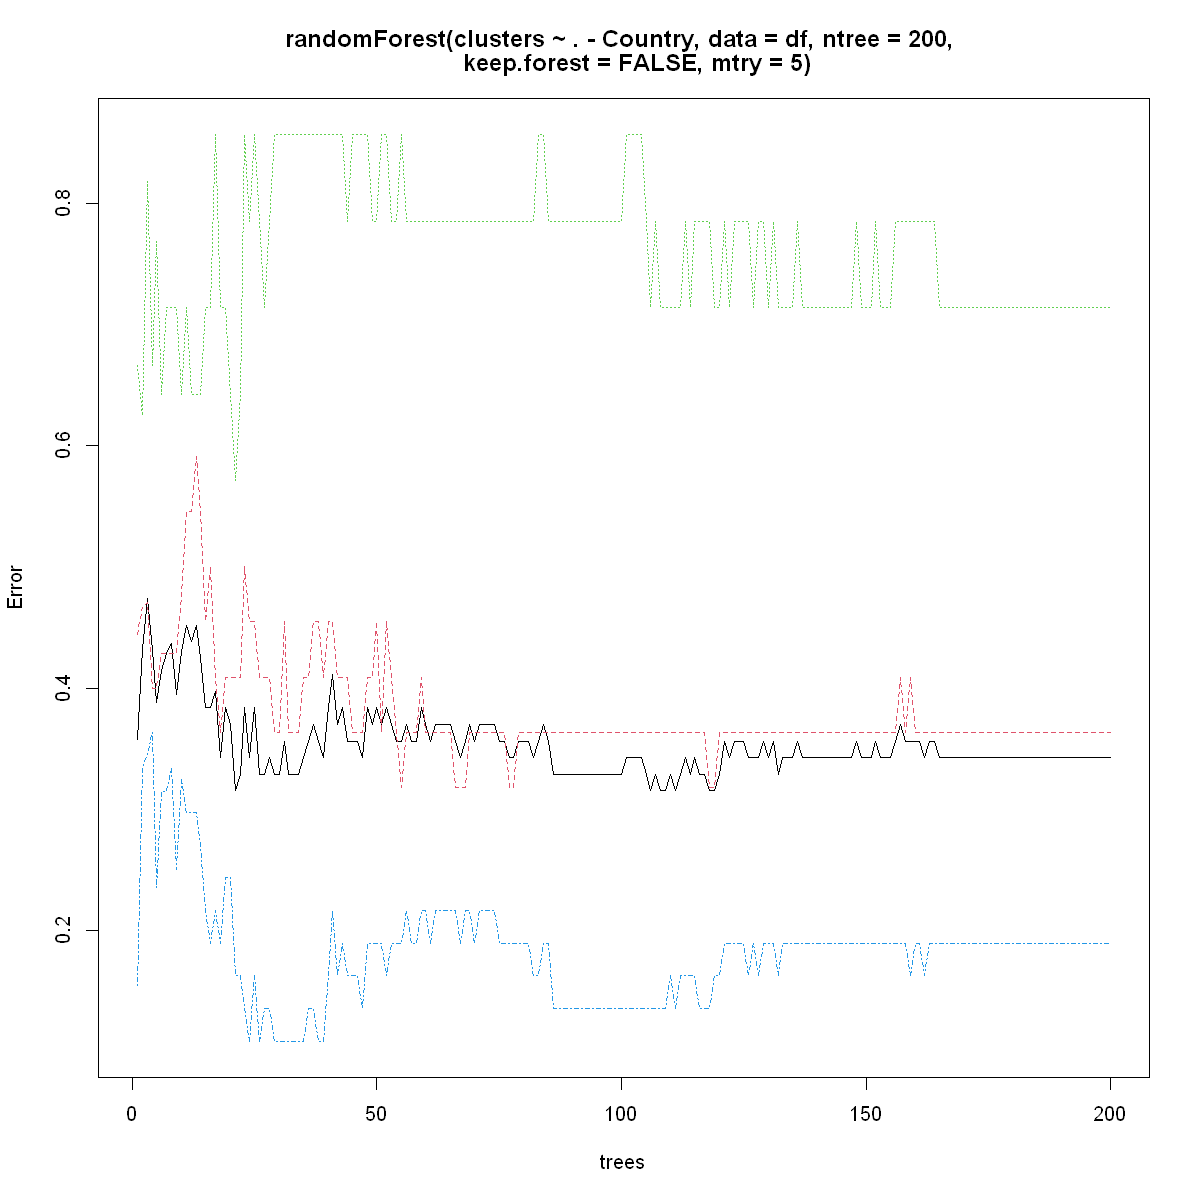

In [42]:
rf.water = randomForest(clusters~. -Country, data = df , ntree= 200,mtry=12)
print(rf.water)

summary(rf.water)

#importance <- importance(rf.water, sort = TRUE)
#importance

# create an importance plot
varImpPlot(rf.water, sort=TRUE, n.var=min(30, nrow(rf.water$importance)),
           type=NULL, class=NULL, scale=TRUE )
#plot
plot(randomForest(clusters~. -Country, data = df ,ntree=200,  keep.forest=FALSE, mtry=5) )

The MeanDecreaseGini measures the Gini importance = how important the features are over all splits done in the tree/forest - whereas for each individual split the Gini importance indicates how much the Gini criterion = "unequality/heterogeneity" was reduced using this split.
mori, upop, pcar popd, mcyc important and contributed most to obtaining such splits, so they are considered more important.

# MULTINOMIAL LOGISTIC REGRESSION

In [43]:
head(df)
with(df, table( df[,8]),)


,Country,bicy,cart,mcyc,pcar,boat,wigc,clusters,cgdp,tpop,upop,popd,land,rifr,prec
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Afghanistan,30.0,5.8,35.2,11.8,0.0,0.1,Off-premise,18353881130,37172386,25.495,56.93776,652860,1299.0269,327
2,Albania,26.4,3.2,9.6,37.0,0.7,0.1,Market,15147020535,2866376,60.319,104.61226,27400,9361.5460,1485
3,Angola,4.6,1.3,17.8,10.9,0.4,0.3,Off-premise,101353230785,30809762,65.514,24.71305,1246700,4963.6533,1010
4,Armenia,8.6,0.4,0.2,39.2,0.3,0.1,Improved Drinking Water,12457941907,2951776,63.149,103.68022,28470,2329.1833,562
5,Azerbaijan,6.9,3.3,1.1,20.4,0.1,0.0,Improved Drinking Water,47112941176,9939771,55.680,120.23432,82670,823.5207,447
6,Bangladesh,25.1,0.0,6.4,0.8,0.0,0.3,Market,274039092455,161356039,36.632,1239.57931,130170,657.6039,2666



Improved Drinking Water                  Market             Off-premise 
                     22                      14                      37 

In [44]:
head(df)

# Fit the model
model <- nnet::multinom(clusters ~. -Country  , data = df)
# Summarize the model
summary(model)

#z values
z <- summary(model)$coefficients/summary(model)$standard.errors
z
# 2-tailed z test
p <- (1 - pnorm(abs(z), 0, 1)) * 2
p

## extract the coefficients from the model and exponentiate
exp(coef(model))

# Make predictions
predicted.classes <- model %>% predict(df)
head(predicted.classes)

head(pp <- fitted(model))
# Model accuracy
mean(predicted.classes == df$clusters)

fit.MLR <- vglm( clusters ~ bicy + cart + mcyc +
                pcar+boat+wigc+cgdp+tpop+upop+popd+land+rifr+prec ,
                family=multinomial, df)
summary(fit.MLR)




,Country,bicy,cart,mcyc,pcar,boat,wigc,clusters,cgdp,tpop,upop,popd,land,rifr,prec
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Afghanistan,30.0,5.8,35.2,11.8,0.0,0.1,Off-premise,18353881130,37172386,25.495,56.93776,652860,1299.0269,327
2,Albania,26.4,3.2,9.6,37.0,0.7,0.1,Market,15147020535,2866376,60.319,104.61226,27400,9361.5460,1485
3,Angola,4.6,1.3,17.8,10.9,0.4,0.3,Off-premise,101353230785,30809762,65.514,24.71305,1246700,4963.6533,1010
4,Armenia,8.6,0.4,0.2,39.2,0.3,0.1,Improved Drinking Water,12457941907,2951776,63.149,103.68022,28470,2329.1833,562
5,Azerbaijan,6.9,3.3,1.1,20.4,0.1,0.0,Improved Drinking Water,47112941176,9939771,55.680,120.23432,82670,823.5207,447
6,Bangladesh,25.1,0.0,6.4,0.8,0.0,0.3,Market,274039092455,161356039,36.632,1239.57931,130170,657.6039,2666


# weights:  45 (28 variable)
initial  value 80.198697 
iter  10 value 57.216322
iter  10 value 57.216322
iter  20 value 47.077862
iter  30 value 46.658050
iter  40 value 45.597682
iter  40 value 45.597682
iter  50 value 45.385819
iter  50 value 45.385819
iter  60 value 45.315795
iter  70 value 45.206888
iter  80 value 45.062657
iter  90 value 45.050922
iter 100 value 45.045906
final  value 45.045906 
stopped after 100 iterations


Call:
nnet::multinom(formula = clusters ~ . - Country, data = df)

Coefficients:
              (Intercept)          bicy          cart          mcyc
Market      -3.483208e-06 -6.292673e-05 -3.245341e-05  7.875035e-05
Off-premise -5.368456e-06 -3.758932e-04 -6.180157e-05 -2.218002e-04
                     pcar          boat          wigc          cgdp
Market       0.0001495876 -1.596265e-05 -1.334689e-07  1.431549e-11
Off-premise -0.0005849426 -1.839081e-05  2.783200e-06 -3.627061e-11
                    tpop          upop          popd          land
Market      3.154545e-08  2.926455e-05  0.0010845800 -1.180888e-05
Off-premise 6.459252e-08 -4.733271e-04 -0.0009598528  9.116216e-07
                     rifr          prec
Market       2.039547e-05 -0.0001810469
Off-premise -2.703054e-05  0.0008933922

Std. Errors:
             (Intercept)         bicy         cart         mcyc         pcar
Market      6.833731e-17 1.415537e-15 8.747839e-16 2.313423e-15 7.289463e-16
Off-premise 7.230208e-

,(Intercept),bicy,cart,mcyc,pcar,boat,wigc,cgdp,tpop,upop,popd,land,rifr,prec
Market,-50970816615,-44454309545,-37098770675,34040610158,205210674891,-1.373828e+12,-3635792760,2.895206,2.308093,782572044599,41760936902,-395794.92,66494066,-134675844841
Off-premise,-74250365007,-477876553395,-98198268609,-115511679047,-216470694217,-2.526740e+11,248996035731,-4.974167,8.158249,-59711493912,-71433277013,19945.82,-18368952,10895936093


,(Intercept),bicy,cart,mcyc,pcar,boat,wigc,cgdp,tpop,upop,popd,land,rifr,prec
Market,0,0,0,0,0,0,0,3.789102e-03,2.099395e-02,0,0,0,0,0
Off-premise,0,0,0,0,0,0,0,6.552872e-07,4.440892e-16,0,0,0,0,0


,(Intercept),bicy,cart,mcyc,pcar,boat,wigc,cgdp,tpop,upop,popd,land,rifr,prec
Market,0.9999965,0.9999371,0.9999675,1.0000788,1.0001496,0.9999840,0.9999999,1,1,1.0000293,1.0010852,0.9999882,1.000020,0.999819
Off-premise,0.9999946,0.9996242,0.9999382,0.9997782,0.9994152,0.9999816,1.0000028,1,1,0.9995268,0.9990406,1.0000009,0.999973,1.000894


[1] Off-premise Off-premise Off-premise Off-premise Market      Market     
Levels: Improved Drinking Water Market Off-premise

,Improved Drinking Water,Market,Off-premise
1,0.0762354994,1.483614e-04,0.923616139
2,0.2633826824,2.701880e-01,0.466429361
3,0.4621378505,2.001920e-06,0.537860148
4,0.3278636813,3.280699e-01,0.344066382
5,0.3924268494,4.260695e-01,0.181503689
6,0.0002357461,9.984117e-01,0.001352591


[1] 0.7260274

Warning message in slot(family, "linkinv")(eta, extra = extra):
"fitted probabilities numerically 0 or 1 occurred"
Warning message in tfun(mu = mu, y = y, w = w, res = FALSE, eta = eta, extra = extra):
"fitted values close to 0 or 1"
Warning message in checkwz(wz, M = M, trace = trace, wzepsilon = control$wzepsilon):
"2 diagonal elements of the working weights variable 'wz' have been replaced by 1.819e-12"
Warning message in slot(family, "linkinv")(eta, extra = extra):
"fitted probabilities numerically 0 or 1 occurred"
Warning message in tfun(mu = mu, y = y, w = w, res = FALSE, eta = eta, extra = extra):
"fitted values close to 0 or 1"
Warning message in slot(family, "linkinv")(eta, extra = extra):
"fitted probabilities numerically 0 or 1 occurred"
Warning message in tfun(mu = mu, y = y, w = w, res = FALSE, eta = eta, extra = extra):
"fitted values close to 0 or 1"
Warning message in checkwz(wz, M = M, trace = trace, wzepsilon = control$wzepsilon):
"2 diagonal elements of the working w

Warning message in tfun(mu = mu, y = y, w = w, res = FALSE, eta = eta, extra = extra):
"fitted values close to 0 or 1"
Warning message in slot(family, "linkinv")(eta, extra = extra):
"fitted probabilities numerically 0 or 1 occurred"
Warning message in tfun(mu = mu, y = y, w = w, res = FALSE, eta = eta, extra = extra):
"fitted values close to 0 or 1"
Warning message in slot(family, "linkinv")(eta, extra = extra):
"fitted probabilities numerically 0 or 1 occurred"
Warning message in tfun(mu = mu, y = y, w = w, res = FALSE, eta = eta, extra = extra):
"fitted values close to 0 or 1"
Warning message in slot(family, "linkinv")(eta, extra = extra):
"fitted probabilities numerically 0 or 1 occurred"
Warning message in tfun(mu = mu, y = y, w = w, res = FALSE, eta = eta, extra = extra):
"fitted values close to 0 or 1"
Warning message in slot(family, "linkinv")(eta, extra = extra):
"fitted probabilities numerically 0 or 1 occurred"
Warning message in tfun(mu = mu, y = y, w = w, res = FALSE, eta 

Warning message in slot(family, "linkinv")(eta, extra = extra):
"fitted probabilities numerically 0 or 1 occurred"
Warning message in tfun(mu = mu, y = y, w = w, res = FALSE, eta = eta, extra = extra):
"fitted values close to 0 or 1"
Warning message in slot(family, "linkinv")(eta, extra = extra):
"fitted probabilities numerically 0 or 1 occurred"
Warning message in tfun(mu = mu, y = y, w = w, res = FALSE, eta = eta, extra = extra):
"fitted values close to 0 or 1"
Warning message in slot(family, "linkinv")(eta, extra = extra):
"fitted probabilities numerically 0 or 1 occurred"
Warning message in tfun(mu = mu, y = y, w = w, res = FALSE, eta = eta, extra = extra):
"fitted values close to 0 or 1"
Warning message in slot(family, "linkinv")(eta, extra = extra):
"fitted probabilities numerically 0 or 1 occurred"
Warning message in tfun(mu = mu, y = y, w = w, res = FALSE, eta = eta, extra = extra):
"fitted values close to 0 or 1"
Warning message in slot(family, "linkinv")(eta, extra = extra):


Warning message in slot(family, "linkinv")(eta, extra = extra):
"fitted probabilities numerically 0 or 1 occurred"
Warning message in tfun(mu = mu, y = y, w = w, res = FALSE, eta = eta, extra = extra):
"fitted values close to 0 or 1"
Warning message in slot(family, "linkinv")(eta, extra = extra):
"fitted probabilities numerically 0 or 1 occurred"
Warning message in tfun(mu = mu, y = y, w = w, res = FALSE, eta = eta, extra = extra):
"fitted values close to 0 or 1"
Warning message in slot(family, "linkinv")(eta, extra = extra):
"fitted probabilities numerically 0 or 1 occurred"
Warning message in tfun(mu = mu, y = y, w = w, res = FALSE, eta = eta, extra = extra):
"fitted values close to 0 or 1"
Warning message in slot(family, "linkinv")(eta, extra = extra):
"fitted probabilities numerically 0 or 1 occurred"
Warning message in tfun(mu = mu, y = y, w = w, res = FALSE, eta = eta, extra = extra):
"fitted values close to 0 or 1"
Warning message in slot(family, "linkinv")(eta, extra = extra):


Warning message in temp1@family@linkinv(eta = temp1@predictors, extra = temp1@extra):
"fitted probabilities numerically 0 or 1 occurred"
Warning message in temp1@family@linkinv(eta = temp1@predictors, extra = temp1@extra):
"fitted probabilities numerically 0 or 1 occurred"
Warning message in temp1@family@linkinv(eta = temp1@predictors, extra = temp1@extra):
"fitted probabilities numerically 0 or 1 occurred"
Warning message in temp1@family@linkinv(eta = temp1@predictors, extra = temp1@extra):
"fitted probabilities numerically 0 or 1 occurred"
Warning message in temp1@family@linkinv(eta = temp1@predictors, extra = temp1@extra):
"fitted probabilities numerically 0 or 1 occurred"
Warning message in temp1@family@linkinv(eta = temp1@predictors, extra = temp1@extra):
"fitted probabilities numerically 0 or 1 occurred"
Warning message in temp1@family@linkinv(eta = temp1@predictors, extra = temp1@extra):
"fitted probabilities numerically 0 or 1 occurred"
Warning message in temp1@family@linkinv(e


Call:
vglm(formula = clusters ~ bicy + cart + mcyc + pcar + boat + 
    wigc + cgdp + tpop + upop + popd + land + rifr + prec, family = multinomial, 
    data = df)

Coefficients: 
                Estimate Std. Error z value Pr(>|z|)   
(Intercept):1 -2.116e+00  2.135e+00  -0.991  0.32148   
(Intercept):2 -1.064e+01  5.185e+00      NA       NA   
bicy:1         4.629e-03  4.648e-02   0.100  0.92067   
bicy:2         1.191e-01  8.961e-02   1.329  0.18388   
cart:1        -5.103e-03  8.117e-02  -0.063  0.94988   
cart:2        -2.640e-01  2.044e-01      NA       NA   
mcyc:1         1.030e-02  4.744e-02   0.217  0.82809   
mcyc:2         9.462e-02  5.719e-02   1.655  0.09802 . 
pcar:1         2.261e-01  9.518e-02   2.376  0.01750 * 
pcar:2         3.633e-01  1.184e-01   3.068  0.00215 **
boat:1         1.758e+00  1.309e+00   1.343  0.17934   
boat:2        -8.014e-01  1.818e+00  -0.441  0.65930   
wigc:1        -8.587e+00  4.585e+00  -1.873  0.06109 . 
wigc:2         2.378e+00  6.290e+0